# Create Project

In [2]:
#import libraries 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib



# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

In [3]:
## Load in data
fname = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR9Yhcch85ziIad4CyZQqLtYijHgsuENLfyC0YAXlajVbSC7U7s3CUUsfG-OYIKOjTI9DdKZH1xMs3a/pub?output=csv'
# df.to_csv(fname,compression='gzip',index=False)
df= pd.read_csv(fname,index_col=0)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


# Preprocess the data

In [9]:
# ### Train Test Split
## Make x and y variables
drop_feats_ass=["Name","Ticket","Cabin"]
y_ass= df['Survived'].copy()
X = df.drop(columns=['Survived',*drop_feats_ass]).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y_ass, random_state=SEED)



In [10]:
# ### Preprocessing + ColumnTransformer
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

In [11]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
355,3.0,30.314472,0.0,0.0,7.225,1.0,1.0,0.0,0.0,0.0
519,2.0,36.000000,1.0,0.0,26.000,0.0,0.0,0.0,0.0,1.0
814,3.0,6.000000,4.0,2.0,31.275,0.0,0.0,0.0,0.0,1.0


# Fit Model: Random Forest

In [12]:
## fit random forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_df,y_train)

RandomForestClassifier()

In [13]:
rf_clf.score(X_test_df, y_test)


0.8475336322869955

# SHAP

In [14]:
# Import shap and initialize javascript:
import shap
shap.initjs()

In [15]:
X_shap = shap.sample(X_test_df,nsamples=400,random_state=321)
X_shap

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
355,3.0,30.314472,0.0,0.0,7.2250,1.0,1.0,0.0,0.0,0.0
519,2.0,36.000000,1.0,0.0,26.0000,0.0,0.0,0.0,0.0,1.0
814,3.0,6.000000,4.0,2.0,31.2750,0.0,0.0,0.0,0.0,1.0
387,3.0,1.000000,5.0,2.0,46.9000,1.0,0.0,0.0,0.0,1.0
490,3.0,9.000000,1.0,1.0,15.9000,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
599,3.0,30.314472,0.0,0.0,7.2250,1.0,1.0,0.0,0.0,0.0
740,3.0,30.314472,0.0,0.0,7.8958,1.0,0.0,0.0,0.0,1.0
253,1.0,62.000000,0.0,0.0,26.5500,1.0,0.0,0.0,0.0,1.0


In [16]:
## get the corresponding y-values
y_shap = y_test.loc[X_shap.index]
y_shap 

PassengerId
355    0
519    1
814    0
387    0
490    1
      ..
599    0
740    0
253    0
382    1
536    1
Name: Survived, Length: 223, dtype: int64

### Explainer

In [17]:
explainer = shap.Explainer(rf_clf)
explainer

In [18]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
shap_values.shape

(223, 10, 2)

In [19]:
# get the Numpy
shap_vals_Survived = shap_values[:,:,1]
shap_vals_Survived

.values =
array([[-6.33526011e-02, -2.90542328e-02, -5.01268267e-03, ...,
        -1.09694400e-05,  4.05684574e-03,  2.46934472e-02],
       [ 8.49621800e-02,  2.89058796e-02, -8.37068522e-03, ...,
        -1.18998865e-05, -1.53820161e-03, -5.71726943e-03],
       [-1.01234194e-01,  2.48630805e-01, -6.53712299e-02, ...,
        -9.85161736e-06,  3.18214397e-03, -4.24926477e-03],
       ...,
       [ 9.85832214e-02, -2.30981234e-01, -1.33445908e-02, ...,
        -2.97743746e-04,  1.25678999e-03, -6.69439882e-03],
       [-5.93256379e-02,  1.56884664e-01,  3.27197532e-02, ...,
        -7.89859050e-06,  9.11090728e-03, -4.37138830e-03],
       [ 7.82827000e-02,  1.38682917e-01,  2.70757203e-02, ...,
        -1.16258818e-05,  4.04008261e-03, -2.00506604e-03]])

.base_values =
array([0.37199102, 0.37199102, 0.37199102, 0.37199102, 0.37199102,
       0.37199102, 0.37199102, 0.37199102, 0.37199102, 0.37199102,
       0.37199102, 0.37199102, 0.37199102, 0.37199102, 0.37199102,
       0.3719910

## Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


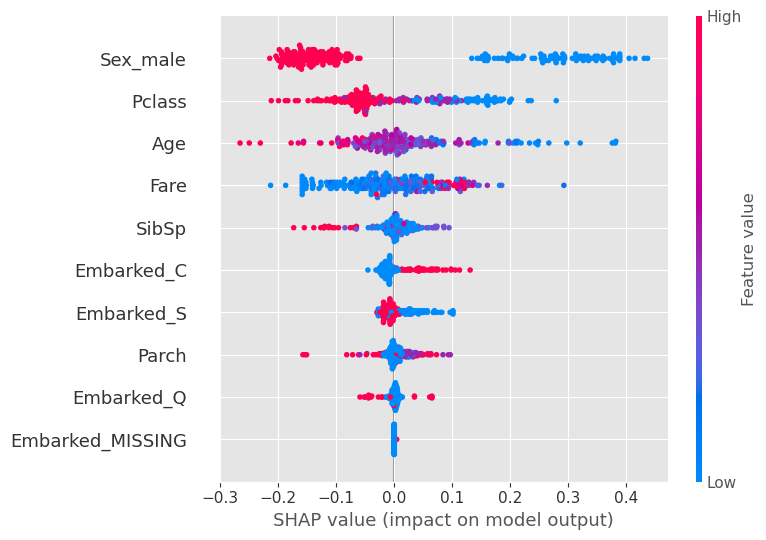

In [20]:
shap.summary_plot(shap_vals_Survived,X_shap)


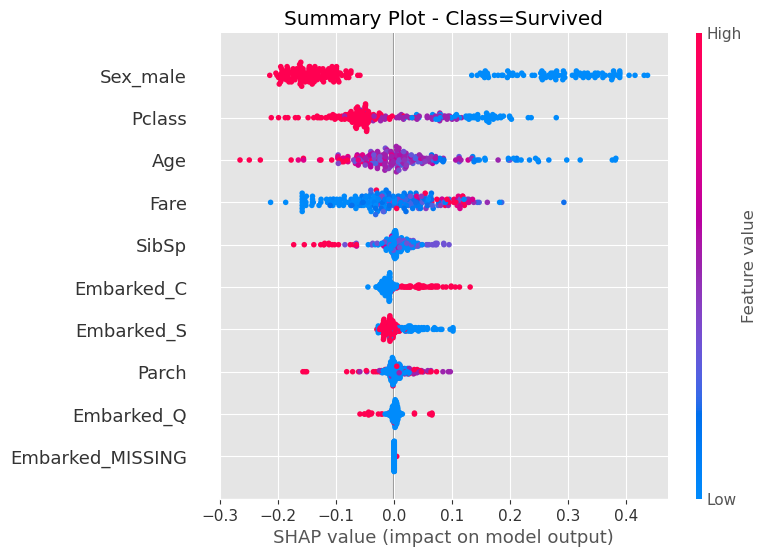

In [24]:
fig, ax = plt.subplots()
shap.summary_plot(shap_vals_Survived,X_shap, show= False)
ax.set_title('Summary Plot - Class=Survived');
fig.savefig('images/summary_plot_titanic.png')

#fig, ax = plt.subplots()
#shap.summary_plot(shap_vals_1, X_shap, show=False)
#ax.set_title('Summary Plot - Class=Fail');
#fig.savefig('images/summary_plot_1.png')

## Summary

- Sex_male: Being male decreased the likelihood of being predicted to be a Survivor

- Fare:The higher the fare, the more likely the model will predict they will Survive.

- Pclass:The better the passenger class (lower is better) the more likely the model will predict they will Survive.

- Age:The older the passenger, the more likely the model will predict them to die.

- SibSp: The more family members, the less likely the model will predict them to Survive.
 #### These make intuitive sense due to "Women and children first", as well as first class passengers being prioritized.